# Mask Detection

## Introduction
Face masks have become a common public sight in the last few months. The Centers for Disease Control (CDC) recently advised the use of simple cloth face coverings to slow the spread of the virus and help people who may have the virus and do not know it from transmitting it to others. Wearing masks is broadly recognised as critical to reducing community transmission and limiting touching of the face.

In a time of concern about slowing the transmission of COVID-19, increased surveillance combined with AI solutions can improve monitoring and reduce the human effort needed to limit the spread of this disease. The objective of this challenge is to create an image classification machine learning model to accurately predict the likelihood that an image contains a person wearing a face mask, or not. The total dataset contains 1,800+ images of people either wearing masks or not.

Your machine learning solution will help policymakers, law enforcement, hospitals, and even commercial businesses ensure that masks are being worn appropriately in public. These solutions can help in the battle to reduce community transmission of COVID-19.

## Process
The process will involve:
* Data Obtainance
* Data Preparation
* Modelling
* Deployment




# Libraries

In [ ]:
# General libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Modelling libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNet, VGG19, InceptionV3, EfficientNetB7

# Data Obtainance

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Variables 
base_path = '/content/drive/MyDrive/Mask Detection'
images_path = '/content/drive/MyDrive/Mask Detection/images'
train_path = '/content/drive/MyDrive/Mask Detection/train_labels.csv'
submission_path = '/content/drive/MyDrive/Mask Detection/sample_sub_v2.csv'


TARGET_SIZE = 512
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.0001

In [ ]:
# Load the train and submission cvs files
images = pd.read_csv(train_path)
submission = pd.read_csv(submission_path)

# Data Preparation

**Explore CSV**

In [ ]:
# View images
images.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [ ]:
# How many images does it have
files = os.listdir(images_path)
print(f'The number of files: {len(files)}')

images.info()

The number of files: 1817
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1308 non-null   object
 1   target  1308 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.6+ KB


About 509 images are not in the train.csv. Let's check whether they are in the submission file

In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   509 non-null    object
 1   target  509 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.1+ KB


In [ ]:
test = submission.drop('target', axis=1)

They are in here

In [ ]:
# Check distribution of target values
images['target'].value_counts()

0    664
1    644
Name: target, dtype: int64

**Visualize some images**

In [ ]:
def show_images(the_path, class_name):
    # Get images 
    print(f'{class_name}')
    # Extract 16 random images from it
    if class_name == 0:
      images_zero = images.loc[images['target']==0]
      random_images = [np.random.choice(images_zero['image'].values) for i in range(8)]
    else:
      images_ones = images.loc[images['target']==1]
      random_images = [np.random.choice(images_ones['image'].values) for i in range(8)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
  
    for i in range(8):
        plt.subplot(2,4,i+1)
        img = plt.imread(os.path.join(the_path, random_images[i]))
        
        try:
          plt.imshow(img, cmap='gray')
          #plt.axis('off')
        except FileNotFoundError:
          pass

    # Adjust subplot parameters to give specified padding
    plt.tight_layout() 

0


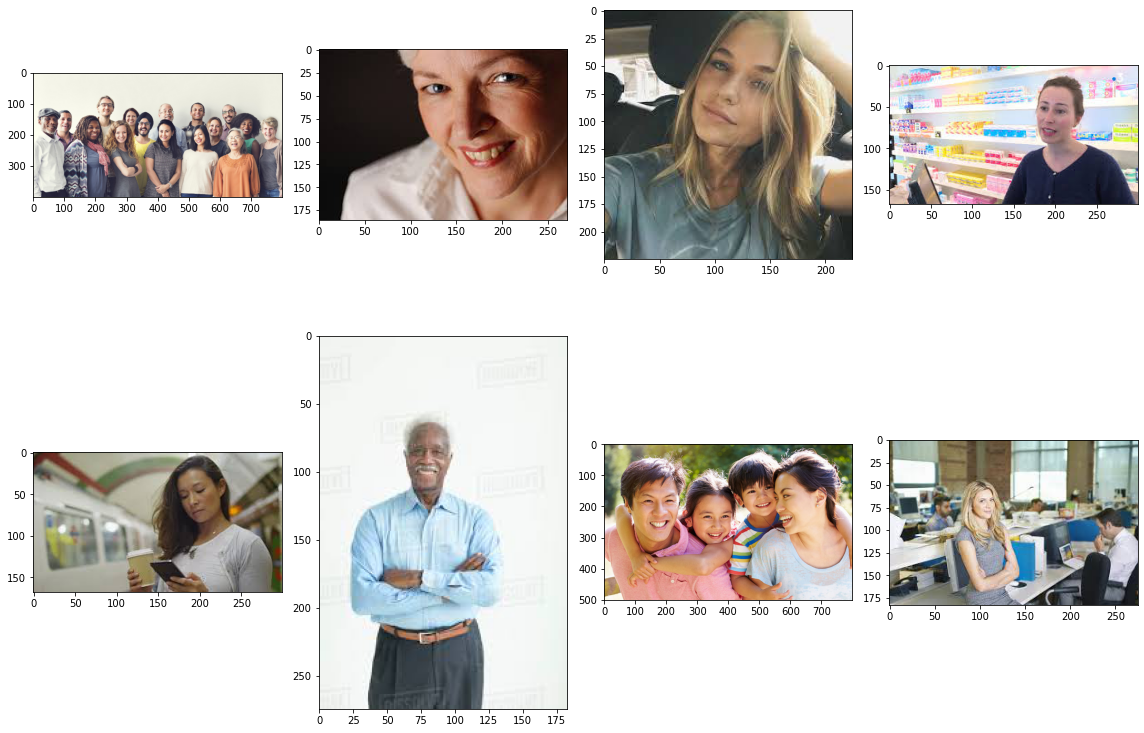

In [ ]:
# View images
show_images(images_path, 0)

1


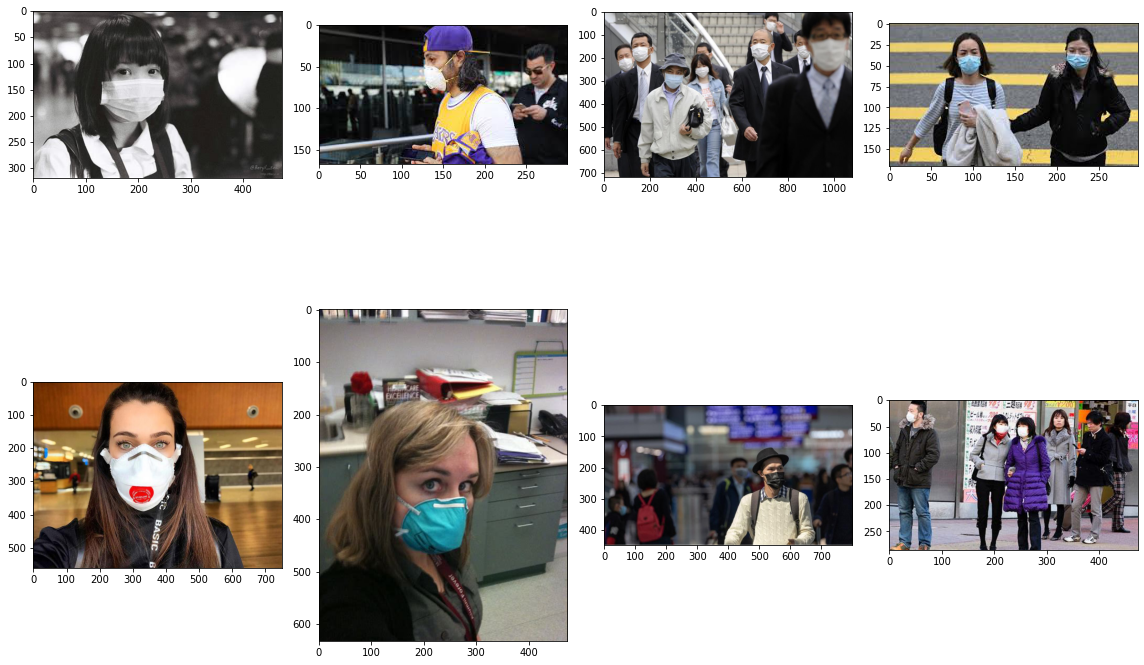

In [ ]:
show_images(images_path, 1)

The images will need reshaping

**Create Validation Dataset**

In [ ]:
images['target'] = images['target'].astype(int).astype(str)

In [ ]:
images

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1
...,...,...
1303,hxjwafskxmlfaotwaklzuwuccsbxfu.jpg,0
1304,oyodauphffgmzmvqlykcfvmyxartok.jpg,1
1305,uppvtemhkneqggtbfubeccqjvyefiw.png,1
1306,mzjjvzkzvqmyukzsegtoktaslejcdz.jpg,0


In [ ]:
# Split
train, validation = train_test_split(images, 
                               train_size=0.95, 
                               random_state=42,
                               stratify=images['target'])

train.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

**Data Generator**

In [ ]:
# Create Generator objects
train_generator = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = True,
    rotation_range = 30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2, 
    brightness_range=[0.8, 2],
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input 
    #rescale=1./255
)

val_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
    #rescale=1./255.
)


In [ ]:
# Create flows
train_flow = train_generator.flow_from_dataframe(train,
                                                 images_path, 
                                                 x_col='image',
                                                 y_col = 'target', 
                                                 target_size=(TARGET_SIZE, TARGET_SIZE), 
                                                 class_mode='binary',
                                                 batch_size = BATCH_SIZE)


val_flow = val_generator.flow_from_dataframe(validation,
                                             images_path,
                                             x_col='image',
                                             y_col = 'target', 
                                             target_size=(TARGET_SIZE, TARGET_SIZE), 
                                             class_mode='binary',
                                             batch_size = BATCH_SIZE)


Found 1242 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


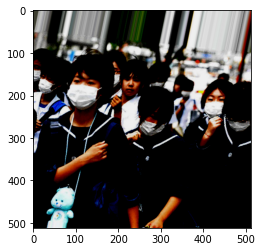

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


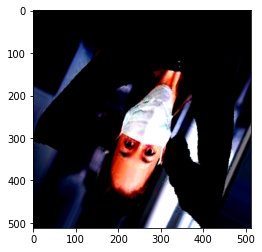

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


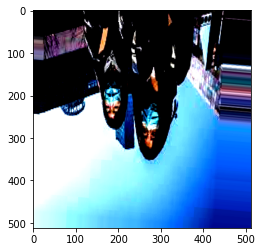

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


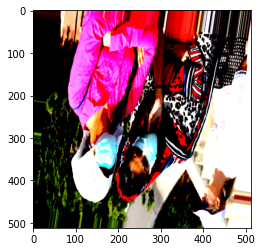

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


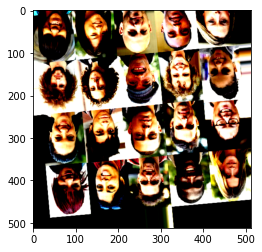

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


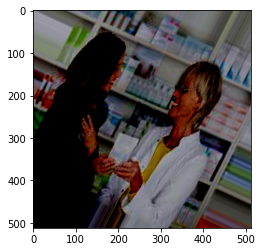

In [ ]:
# Visualize
x_batch, y_batch = next(train_flow)
for i in range (0,6):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

# Modelling

In [ ]:
def create_model():
  
  # Build model
  inception =InceptionV3(include_top=False, 
                          input_shape=(TARGET_SIZE, TARGET_SIZE, 3))
  
  for layer in inception.layers:
    layer.trainable = True

  model = Sequential([
                      
                      inception,
                      GlobalAveragePooling2D(),
                      #Flatten(),
                      Dense(256, activation = 'relu'),
                      Dense(32, activation = 'relu'),

                      #Dropout(0.5),
                      Dense(1, activation = 'sigmoid')
  ])

  # Instantiate learning rate and optimizer
  loss = tf.keras.losses.BinaryCrossentropy(from_logits = False,
                                                   label_smoothing=0.01,
                                                   name='binary_crossentropy' )

  adam = tf.keras.optimizers.Adam(LR)
  
  
  # Compile model
  model.compile(loss = loss,
                optimizer = adam,
                metrics = ['accuracy'])
  
  return model

In [ ]:
def model_fitter(model):

  # instantiate callbacks
  
  early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 patience=15)

  # reduce learning rate
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
  checkpoint = tf.keras.callbacks.ModelCheckpoint('content/Best.h5', monitor='val_loss', mode = 'min' , verbose=1, save_best_only=True, save_weights_only=False)

  callbacks = [early_stopper, reduce_lr, checkpoint]

  # Train model
  history = model.fit(train_flow,
                    epochs=EPOCHS,
                    steps_per_epoch=int(np.ceil(train_flow.samples)/BATCH_SIZE),
                    callbacks=callbacks,
                    validation_data=val_flow,
                    validation_steps=int(np.ceil(val_flow.samples)/BATCH_SIZE)
                    )
  
  return history, model

In [ ]:
# Train model
model = create_model()



87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Train model
history, model = model_fitter(model)

Epoch 1/20
38/38 [==============================] - 462s 11s/step - loss: 0.3815 - accuracy: 0.8314 - val_loss: 0.0826 - val_accuracy: 0.9844

Epoch 00001: val_loss improved from inf to 0.08259, saving model to content/Best.h5
Epoch 2/20
38/38 [==============================] - 139s 4s/step - loss: 0.1737 - accuracy: 0.9455 - val_loss: 0.1182 - val_accuracy: 0.9688

Epoch 00002: val_loss did not improve from 0.08259
Epoch 3/20
38/38 [==============================] - 138s 4s/step - loss: 0.1506 - accuracy: 0.9446 - val_loss: 0.0482 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.08259 to 0.04819, saving model to content/Best.h5
Epoch 4/20
38/38 [==============================] - 138s 4s/step - loss: 0.0964 - accuracy: 0.9727 - val_loss: 0.0432 - val_accuracy: 1.0000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00004: val_loss improved from 0.04819 to 0.04318, saving model to content/Best.h5
Epoch 5/20
38/38 [=====================

In [ ]:
def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **accuracy**

    :param all: bool
    default=True. If true, overrides metric and plots figures of accuracy and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation accuracy',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train accuracy',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation accuracy plots',
                             xaxis_title='Epochs',
                             yaxis_title='accuracy')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['accuracy']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='accuracy',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='accuracy plot',
                             xaxis_title='Epochs',
                             yaxis_title='accuracy')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()


In [ ]:
plot_interactive_figures(history, 'accuracy')

In [ ]:
# Evaluate model
model.evaluate(val_flow)

3/3 [==============================] - 4s 1s/step - loss: 0.0403 - accuracy: 1.0000


[0.04031278192996979, 1.0]

**Generate Predictions**

In [ ]:
# Instantiate generator
test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input

)

In [ ]:
# Instantiate flow
test_flow = test_generator.flow_from_dataframe(test,
                                               images_path,
                                               x_col='image',
                                               y_col = None,
                                               class_mode=None,
                                               target_size=(TARGET_SIZE, TARGET_SIZE),
                                               batch_size = BATCH_SIZE, 
                                               shuffle=False)

Found 509 validated image filenames.


In [ ]:
# Get Predictions
predictions = model.predict(test_flow)

In [ ]:
predictions

array([[9.85780776e-01],
       [7.24301487e-03],
       [9.98635590e-01],
       [9.95170057e-01],
       [2.46483181e-03],
       [7.53542781e-03],
       [9.96436357e-01],
       [6.23908266e-03],
       [2.17812881e-03],
       [9.98137712e-01],
       [1.07763195e-03],
       [1.52493664e-03],
       [9.94574904e-01],
       [9.92994130e-01],
       [9.97181177e-01],
       [4.95279627e-03],
       [8.55360091e-01],
       [9.96678114e-01],
       [5.95865631e-03],
       [9.96760070e-01],
       [6.84141833e-03],
       [1.27745129e-03],
       [9.99735177e-01],
       [1.68762205e-03],
       [3.94242676e-03],
       [9.90223348e-01],
       [9.99103367e-01],
       [1.98721942e-02],
       [9.92100656e-01],
       [9.98018265e-01],
       [1.36093665e-02],
       [3.08861375e-01],
       [9.93153572e-01],
       [9.91031170e-01],
       [9.76763129e-01],
       [3.72941198e-04],
       [1.83442479e-03],
       [9.98077750e-01],
       [1.61238399e-03],
       [9.85388458e-01],


**Submit Predictions**

In [ ]:
submission['target'] = predictions

In [ ]:
submission.rename(columns={'image':'id', 'target':'label'}, inplace=True)

In [ ]:
submission.to_csv('submission.csv', index=False)